In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import models,layers
import matplotlib.pyplot as plt

In [2]:
img_size=256
Batch_size=32
channels=3
epochs=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    shuffle=True,
    image_size=(img_size,img_size),
    batch_size=Batch_size
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names =dataset.class_names

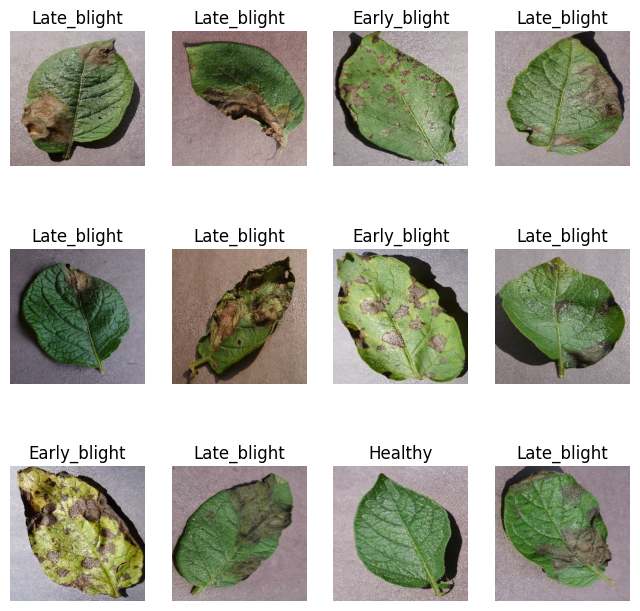

In [5]:
for image_batch,label_batch in dataset.take(1):
    plt.figure(figsize=(8,8))
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    

In [6]:
def get_dataset_partitions(dataset,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    
    ds_size=len(dataset)

    if shuffle:
        dataset=dataset.shuffle(shuffle_size,seed=12)

    train_size=int(train_split*ds_size)
    test_size=int(test_split*ds_size)
    
    train_ds=dataset.take(train_size)
    temp_test=dataset.skip(train_size)
    val_ds=temp_test.take(test_size)
    test_ds=temp_test.skip(test_size)

    return train_ds,val_ds,test_ds

In [7]:
train_ds,val_ds,test_ds = get_dataset_partitions(dataset)

In [8]:
len(train_ds)

54

In [9]:
len(test_ds)

8

In [10]:
len(val_ds)

6

In [11]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(img_size,img_size),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

AttributeError: module 'keras.layers' has no attribute 'experimental'

In [ ]:
tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

AttributeError: module 'keras.layers' has no attribute 'experimental'